In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from IPython.display import display, HTML
from scipy.stats import rankdata
from Orange.evaluation import compute_CD, graph_ranks

sns.set_style("ticks", {
    'axes.grid': True,
    'grid.color': '.5'})
sns.set_context("paper")
# sns.set_palette("crest")
# sns.color_palette("muted")
# sns.color_palette("crest", as_cmap=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
EVALMETRIC = 'roc_auc'

In [3]:
df = pd.read_csv("results_df/undersampling_exp.csv", index_col=0)
df.loc[df.parameters.str.contains(pat="majority_left_threshold': 0.0"), 'undersampling_method'] = 'hypper_equal'
df.head(3)

,dataset,undersampling_method,eval_algorithm,parameters,accuracy_val,balanced_accuracy_val,roc_auc_val,average_precision_val,precision_val,recall_val,f1_val,accuracy_test,balanced_accuracy_test,roc_auc_test,average_precision_test,precision_test,recall_test,f1_test
0,read_german_data,hypper_equal,LogisticRegression,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.634731,0.695292,0.790260,0.892308,0.833137,0.517857,0.655367,0.622754,0.671676,0.718033,0.873418,0.848003,0.565574,0.686567
1,read_german_data,hypper_equal,MLPClassifier,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.706587,0.684091,0.753734,0.800000,0.838609,0.750000,0.774194,0.718563,0.688160,0.734973,0.844037,0.857878,0.754098,0.796537
2,read_german_data,hypper_equal,CatBoostClassifier,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.622754,0.686364,0.773701,0.888889,0.848463,0.500000,0.640000,0.604790,0.680419,0.756102,0.900000,0.866565,0.516393,0.656250


In [4]:
print(f"Undersampling methods: {df['undersampling_method'].unique().tolist()}")
print(f"Datasets: {df['dataset'].unique().tolist()}")
print(f"Evaluation models: {df['eval_algorithm'].unique().tolist()}")
# print(f"Parameters sets: {df['parameters'].unique().tolist()}")

Undersampling methods: ['hypper_equal', 'hypper', 'without_undersampling', 'tomek_links', 'edited_nearest_neighbours', 'random_undersampling', 'near_miss']
Datasets: ['read_german_data', 'read_spect_heart', 'read_banking', 'read_hr', 'read_criteo']
Evaluation models: ['LogisticRegression', 'MLPClassifier', 'CatBoostClassifier', 'LGBMClassifier']


In [10]:
# Select best hypper params validation data
tuned_methods = ['hypper', 'hypper_equal', 'near_miss', 'random_undersampling']
grouping_key = ['undersampling_method','dataset','eval_algorithm','parameters']
df_test = df[df.undersampling_method.isin(tuned_methods)]

df_test = df_test.groupby(grouping_key).mean()
metric = [EVALMETRIC+'_val', EVALMETRIC+'_test']
df_test = df_test[metric].sort_values(by=EVALMETRIC+'_val', ascending=False)
df_test = df_test.groupby(grouping_key[:-1]).head(1).reset_index().set_index(grouping_key).sort_index()
best_params = list(df_test.index)
print(len(best_params))
best_params[:2]

80


[('hypper',
  'read_banking',
  'CatBoostClassifier',
  "{'majority_left_threshold': 0.7, 'method': 'hypper', 'randomize_A': 15.0, 'version': 5, 'weighting_history': True, 'weighting_iteration': 2, 'weighting_normalization_strategy': 'l1'}"),
 ('hypper',
  'read_banking',
  'LGBMClassifier',
  "{'majority_left_threshold': 0.7, 'method': 'hypper', 'randomize_A': 15.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 2, 'weighting_normalization_strategy': 'l1'}")]

In [11]:
print(df.shape)
df_best = deepcopy(df)
df_best = df_best.set_index(grouping_key)
df_best = df_best[
    (~df_best.index.isin(tuned_methods, level='undersampling_method')) |
    (df_best.index.isin(best_params))
].sort_index().reset_index()
df_best.shape

(26400, 18)


(420, 18)

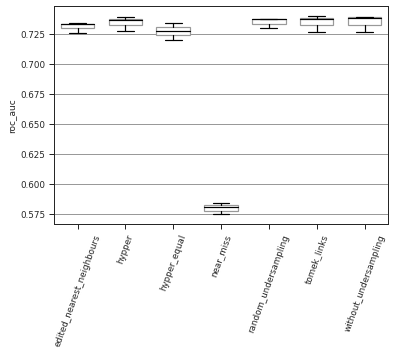

In [12]:
DATASET = 'read_criteo'
EVALALG = 'CatBoostClassifier'

df_plot = df_best[df_best.dataset == DATASET]
df_plot = df_plot[df_plot.eval_algorithm == EVALALG]

f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_plot, x='undersampling_method', y=EVALMETRIC+'_test', ax=ax, color='white', width=.7, fliersize=3)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
plt.xticks(rotation=70)
ax.set_ylabel(EVALMETRIC, fontsize=9)
ax.set_xlabel(None, fontsize=6, weight='bold')
# ax.set_xticklabels(['Without\nundersampling', 'Hypper', 'Tomek\nLinks', 'Random', 'ENN', 'Near-Miss'])
f.savefig(f'results_plots/under_criteo_{EVALMETRIC}.pdf')
plt.show()

Undersampling methods: ['edited_nearest_neighbours', 'hypper', 'hypper_equal', 'near_miss', 'random_undersampling', 'tomek_links', 'without_undersampling']
Shape: (105, 18)
edited_nearest_neighbours average rank: 5.2
hypper average rank: 2.6
hypper_equal average rank: 4.6
near_miss average rank: 6.6
random_undersampling average rank: 2.6
tomek_links average rank: 3.4
without_undersampling average rank: 3.0


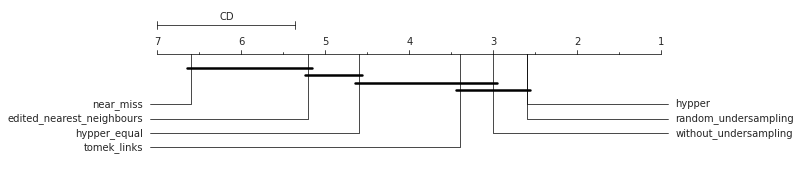

In [13]:
# Friedman test - https://edisciplinas.usp.br/pluginfile.php/4129451/mod_resource/content/1/model_selection_evaluation.pdf
df_eval_metric = df_best[df_best.eval_algorithm == EVALALG].set_index(grouping_key).sort_index().reset_index()
u_methods = df_eval_metric['undersampling_method'].unique().tolist()
datasets = df_eval_metric['dataset'].unique().tolist()
kfolds = 5
print(f"Undersampling methods: {u_methods}")
print(f"Shape: {df_eval_metric.shape}")

df_eval_metric['experiment_num'] = pd.Series(list(range(1,kfolds+1))*len(u_methods)*len(datasets))

# display(df_eval_metric[grouping_key+['experiment_num']+[EVALMETRIC+'_test']].head(50))

performance_array = df_eval_metric.groupby(['dataset', 'experiment_num'])[EVALMETRIC+'_test'].apply(np.array)
# performance_array
ranks = np.array([rankdata(-p) for p in performance_array])
# print(ranks[:5])
average_ranks = np.mean(ranks, axis=0)
# print(average_ranks)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(u_methods, average_ranks)))

cd = compute_CD(average_ranks,
                n=len(datasets)*kfolds,
                alpha='0.1',
                test='nemenyi')
# This method generates the plot.
graph_ranks(average_ranks,
            names=u_methods,
            cd=cd,
            width=10,
            textspace=1.5,
            reverse=True)
plt.savefig('results_plots/under_friedman.pdf')
plt.show()

#### Random vs Hypper

In [24]:
df = pd.read_csv("results_df/undersampling_exp.csv", index_col=0)
df = df[df.undersampling_method.isin(["hypper", "random_undersampling"])]
for threshold in [0.0, 0.5, 0.7]:
    for ua in ['hypper', 'random_undersampling']:
        df.loc[
            df.parameters.str.contains(pat=f"majority_left_threshold': {threshold}") & \
            (df.undersampling_method == ua), 'undersampling_method'] = f'{ua}_{threshold}'
df.head(3)

,dataset,undersampling_method,eval_algorithm,parameters,accuracy_val,balanced_accuracy_val,roc_auc_val,average_precision_val,precision_val,recall_val,f1_val,accuracy_test,balanced_accuracy_test,roc_auc_test,average_precision_test,precision_test,recall_test,f1_test
0,read_german_data,hypper_0.0,LogisticRegression,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.634731,0.695292,0.790260,0.892308,0.833137,0.517857,0.655367,0.622754,0.671676,0.718033,0.873418,0.848003,0.565574,0.686567
1,read_german_data,hypper_0.0,MLPClassifier,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.706587,0.684091,0.753734,0.800000,0.838609,0.750000,0.774194,0.718563,0.688160,0.734973,0.844037,0.857878,0.754098,0.796537
2,read_german_data,hypper_0.0,CatBoostClassifier,"{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 0.0, 'version': 1, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'max'}",0.622754,0.686364,0.773701,0.888889,0.848463,0.500000,0.640000,0.604790,0.680419,0.756102,0.900000,0.866565,0.516393,0.656250


In [25]:
print(f"Undersampling methods: {df['undersampling_method'].unique().tolist()}")
print(f"Datasets: {df['dataset'].unique().tolist()}")
print(f"Evaluation models: {df['eval_algorithm'].unique().tolist()}")

Undersampling methods: ['hypper_0.0', 'hypper_0.5', 'hypper_0.7', 'random_undersampling_0.0', 'random_undersampling_0.5', 'random_undersampling_0.7']
Datasets: ['read_german_data', 'read_spect_heart', 'read_banking', 'read_hr', 'read_criteo']
Evaluation models: ['LogisticRegression', 'MLPClassifier', 'CatBoostClassifier', 'LGBMClassifier']


In [26]:
tuned_methods = ['hypper_0.0', 'hypper_0.5', 'hypper_0.7', 'random_undersampling_0.0', 'random_undersampling_0.5', 'random_undersampling_0.7']
grouping_key = ['undersampling_method','dataset','eval_algorithm','parameters']
df_test = df[df.undersampling_method.isin(tuned_methods)]

df_test = df_test.groupby(grouping_key).mean()
metric = [EVALMETRIC+'_val', EVALMETRIC+'_test']
df_test = df_test[metric].sort_values(by=EVALMETRIC+'_val', ascending=False)
df_test = df_test.groupby(grouping_key[:-1]).head(1).reset_index().set_index(grouping_key).sort_index()
best_params = list(df_test.index)
print(len(best_params))
best_params[:2]

120


[('hypper_0.0',
  'read_banking',
  'CatBoostClassifier',
  "{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 40.0, 'version': 5, 'weighting_history': True, 'weighting_iteration': 3, 'weighting_normalization_strategy': 'l2'}"),
 ('hypper_0.0',
  'read_banking',
  'LGBMClassifier',
  "{'majority_left_threshold': 0.0, 'method': 'hypper', 'randomize_A': 15.0, 'version': 5, 'weighting_history': True, 'weighting_iteration': 1, 'weighting_normalization_strategy': 'l1'}")]

In [27]:
print(df.shape)
df_best = deepcopy(df)
df_best = df_best.set_index(grouping_key)
df_best = df_best[
    (~df_best.index.isin(tuned_methods, level='undersampling_method')) |
    (df_best.index.isin(best_params))
].sort_index().reset_index()
df_best.shape

(26100, 18)


(360, 18)

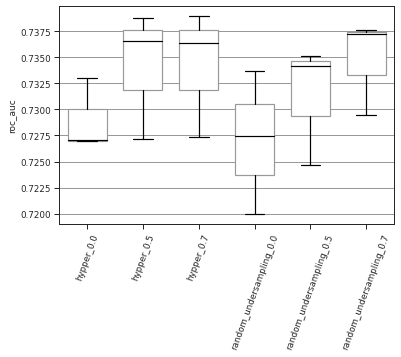

In [28]:
DATASET = 'read_criteo'
EVALALG = 'CatBoostClassifier'

df_plot = df_best[df_best.dataset == DATASET]
df_plot = df_plot[df_plot.eval_algorithm == EVALALG]

f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_plot, x='undersampling_method', y=EVALMETRIC+'_test', ax=ax, color='white', width=.7, fliersize=3)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
plt.xticks(rotation=70)
ax.set_ylabel(EVALMETRIC, fontsize=9)
ax.set_xlabel(None, fontsize=6, weight='bold')
# ax.set_xticklabels(['Without\nundersampling', 'Hypper', 'Tomek\nLinks', 'Random', 'ENN', 'Near-Miss'])
f.savefig(f'results_plots/underrandom_criteo_{EVALMETRIC}.pdf')
plt.show()

Undersampling methods: ['hypper_0.0', 'hypper_0.5', 'hypper_0.7', 'random_undersampling_0.0', 'random_undersampling_0.5', 'random_undersampling_0.7']
Shape: (90, 18)
hypper_0.0 average rank: 4.666666666666667
hypper_0.5 average rank: 3.066666666666667
hypper_0.7 average rank: 2.9
random_undersampling_0.0 average rank: 4.8
random_undersampling_0.5 average rank: 3.533333333333333
random_undersampling_0.7 average rank: 2.033333333333333


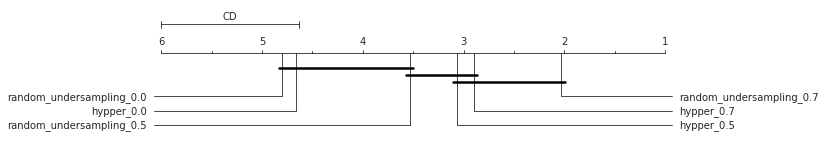

In [29]:
# Friedman test - https://edisciplinas.usp.br/pluginfile.php/4129451/mod_resource/content/1/model_selection_evaluation.pdf
df_eval_metric = df_best[df_best.eval_algorithm == EVALALG].set_index(grouping_key).sort_index().reset_index()
u_methods = df_eval_metric['undersampling_method'].unique().tolist()
datasets = df_eval_metric['dataset'].unique().tolist()
kfolds = 5
print(f"Undersampling methods: {u_methods}")
print(f"Shape: {df_eval_metric.shape}")

df_eval_metric['experiment_num'] = pd.Series(list(range(1,kfolds+1))*len(u_methods)*len(datasets))

# display(df_eval_metric[grouping_key+['experiment_num']+[EVALMETRIC+'_test']].head(50))

performance_array = df_eval_metric.groupby(['dataset', 'experiment_num'])[EVALMETRIC+'_test'].apply(np.array)
# performance_array
ranks = np.array([rankdata(-p) for p in performance_array])
# print(ranks[:5])
average_ranks = np.mean(ranks, axis=0)
# print(average_ranks)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(u_methods, average_ranks)))

cd = compute_CD(average_ranks,
                n=len(datasets)*kfolds,
                alpha='0.1',
                test='nemenyi')
# This method generates the plot.
graph_ranks(average_ranks,
            names=u_methods,
            cd=cd,
            width=10,
            textspace=1.5,
            reverse=True)
plt.savefig('results_plots/underrandom_friedman.pdf')
plt.show()